# VAE(Variational Auto-Encoder)
### VAE 를 통한 데이터 generate 하는 과정의 예시를 보여주기 위한 소스 코드입니다.
- Visible 공간에서 학습에 사용한 데이터를 토대로 Latent 공간으로 투영하는 관계를 찾아 내는 알고리즘을 VAE를 활용할 수 있다.
- 만약, 학습에 사용된 Visible 데이터의 분포에서 크게 벗어난 알지 못하는 데이터를 생성해내는 것은 가능할까?에 대해 확인하기 위해 이 소스코드를 작성하였다.

In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

print('tensorflow ver:', tf.__version__)
print('openCV ver:', cv2.__version__)

/Users/kimsu/py36tf1x/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


tensorflow ver: 1.4.0
openCV ver: 3.4.0


### Data 생성

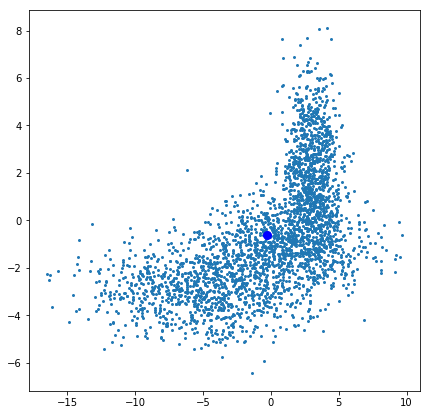

In [2]:
data = np.random.normal(loc=[3, 2], scale=[1, 2], size=[1000,2])
data = np.vstack([data, np.random.normal(loc=[1, -1], scale=[3, 1], size=[1000,2])])
data = np.vstack([data, np.random.normal(loc=[-5, -3], scale=[4, 1], size=[1000,2])])

mu_data = np.mean(data, axis=0)

fig = plt.figure(figsize=(7, 7))
plt.scatter(data[:,0], data[:,1], marker='.', linewidths=0)
plt.scatter(mu_data[0], mu_data[1], marker='o', linewidths=3, c=(0, 0, 1))

### Plotting Function

In [3]:
def scatter_data(x_data, y_data, title="", marker='.', c='b', linewidths=0, figsize=(7, 7)):
    fig = plt.figure(figsize=figsize)
    plt.scatter(x_data, y_data, marker=marker, c=c, linewidths=linewidths)
    plt.title(title, size=15)
    plt.show()

def scatter_2_data(data1, data2, titles=None, marker='.', c1='b', c2='b', linewidths=0, figsize=(15, 7)):
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.scatter(data1[:, 0], data1[:, 1], marker=marker, c=c1, linewidths=linewidths)
    if titles is not None:
        plt.title(titles[0], size=15)
    
    plt.subplot(1, 2, 2)
    plt.scatter(data2[:, 0], data2[:, 1], marker=marker, c=c2, linewidths=linewidths)
    if titles is not None:
        plt.title(titles[1], size=15)
    plt.show()
    
def scatter_2_data_test_sample(data1, data2, sample1, sample2, titles=None, marker='.', c1='b', c2='b', linewidths=0, figsize=(15, 7)):
    fig = plt.figure(figsize=figsize)
    sample_color = np.random.rand(len(sample1), 3)
    plt.subplot(1, 2, 1)
    plt.scatter(data1[:, 0], data1[:, 1], marker=marker, c=c1, linewidths=linewidths)
    plt.scatter(sample1[:, 0], sample1[:,1], marker='x', c=sample_color, linewidths=10)
    if titles is not None:
        plt.title(titles[0], size=15)
    
    plt.subplot(1, 2, 2)
    plt.scatter(data2[:, 0], data2[:, 1], marker=marker, c=c2, linewidths=linewidths)
    plt.scatter(sample2[:, 0], sample2[:,1], marker='x', c=sample_color, linewidths=10)
    if titles is not None:
        plt.title(titles[1], size=15)
    plt.show()

### VAE

In [4]:
# Gaussian MLP as encoder
def gaussian_MLP_encoder(x, n_hidden, n_output, keep_prob):
    with tf.variable_scope("gaussian_MLP_encoder"):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(x, w0) + b0
        h0 = tf.nn.elu(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.tanh(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer
        # borrowed from https: // github.com / altosaar / vae / blob / master / vae.py
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output * 2], initializer=w_init)
        bo = tf.get_variable('bo', [n_output * 2], initializer=b_init)
        gaussian_params = tf.matmul(h1, wo) + bo

        # The mean parameter is unconstrained
        mean = gaussian_params[:, :n_output]
        # The standard deviation must be positive. Parametrize with a softplus and
        # add a small epsilon for numerical stability
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:, n_output:])

    return mean, stddev

# Bernoulli MLP as decoder
def MLP_decoder(z, n_hidden, n_output, keep_prob, reuse=False):

    with tf.variable_scope("bernoulli_MLP_decoder", reuse=reuse):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [z.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(z, w0) + b0
        h0 = tf.nn.tanh(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.elu(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer-mean
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output], initializer=w_init)
        bo = tf.get_variable('bo', [n_output], initializer=b_init)
#         y = tf.sigmoid(tf.matmul(h1, wo) + bo)
        y = tf.matmul(h1, wo) + bo

    return y

# Gateway
def autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob):

    # encoding
    mu, sigma = gaussian_MLP_encoder(x_hat, n_hidden, dim_z, keep_prob)

    # sampling by re-parameterization technique
    z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)

    # decoding
    y = MLP_decoder(z, n_hidden, dim_img, keep_prob)
#     y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)

#     # loss
#     marginal_likelihood = tf.reduce_sum(x * tf.log(y) + (1 - x) * tf.log(1 - y), 1)
#     KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, 1)

#     marginal_likelihood = tf.reduce_mean(marginal_likelihood)
#     KL_divergence = tf.reduce_mean(KL_divergence)

#     ELBO = marginal_likelihood - KL_divergence

#     loss = -ELBO
    # loss
    mse = tf.reduce_sum(tf.squared_difference(x, y))
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, 1)

    mse = tf.reduce_mean(mse)
    KL_divergence = tf.reduce_mean(KL_divergence)

    loss = mse + KL_divergence

    return y, z, loss, mse, KL_divergence

def decoder(z, dim_data, n_hidden):

    y = MLP_decoder(z, n_hidden, dim_data, 1.0, reuse=True)

    return y

### Dataset Dividing

In [5]:
rnd_data = data.copy()
np.random.shuffle(rnd_data)

In [6]:
train_set_ratio = 0.8

n_data = len(rnd_data)
n_train_data = int(n_data * train_set_ratio)

train_data = rnd_data[:n_train_data]
test_data = rnd_data[n_train_data:]

cur_idx = 0

In [7]:
def next_batch(data, idx, batch_size):
    batch = data[idx:idx+batch_size]
    idx = idx + len(batch)
    if len(batch) == 0:
        np.random.shuffle(data)
        batch = data[:batch_size]
        idx = batch_size
    return batch, idx

def add_noise(data, sig=0.01):
    data_hat = data + np.random.normal(scale=sig, size=data.shape)
    return data_hat

### build Graph

In [8]:
dim_data = 2
dim_z = 2
learning_rate = 1e-4

n_hidden=10

In [9]:
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_data], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_data], name='target_img')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

# network architecture
y, z, loss, mse, KL_divergence = autoencoder(x_hat, x, dim_data, dim_z, n_hidden, keep_prob)

# Decoder for Generating new Datas
decoded = decoder(z_in, dim_data, n_hidden)

# optimization
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

### Train

In [15]:
batch_size = 128
n_samples = len(train_data)

# train
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99

n_epochs = 10000
n_iter = n_epochs * total_batch

logs_step = n_iter // 100
draw_step = n_iter // 20
save_step = n_iter // 10

In [16]:
def get_color(data):
    data_len = len(data)
    diff = data - mu_data
    norm_diff = np.linalg.norm(diff, axis=1)
    ang = np.arccos(diff[:,0] / norm_diff) / np.pi * 90
    normalized_norm_diff = norm_diff / norm_diff.max()
    
    hsv = np.vstack([ang, normalized_norm_diff * 255, np.ones(data_len) * 255])
    hsv = hsv.transpose()
    hsv = hsv.reshape([-1, data_len, 3])
    hsv = hsv.astype(np.uint8)
    
    rgb_color = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb_color

In [17]:
test_rgb_color = get_color(test_data)

test_rgb_color = test_rgb_color.astype(np.float) / 255
test_rgb_color = test_rgb_color.tolist()[0]

Iter 0: L_tot 5172.480 L_MSE 5170.091 L_divergence 2.389


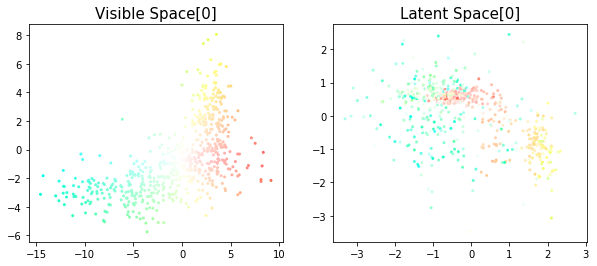

Iter 1800: L_tot 1018.362 L_MSE 1013.711 L_divergence 4.651
Iter 3600: L_tot 891.850 L_MSE 885.577 L_divergence 6.274
Iter 5400: L_tot 1234.412 L_MSE 1227.842 L_divergence 6.570
Iter 7200: L_tot 749.192 L_MSE 742.212 L_divergence 6.980
Iter 9000: L_tot 647.785 L_MSE 639.979 L_divergence 7.806


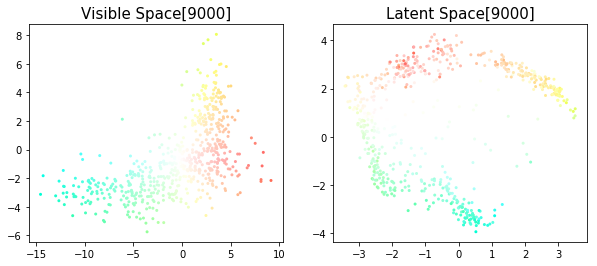

Iter 10800: L_tot 489.712 L_MSE 481.779 L_divergence 7.932
Iter 12600: L_tot 446.979 L_MSE 438.969 L_divergence 8.010
Iter 14400: L_tot 469.014 L_MSE 461.346 L_divergence 7.668
Iter 16200: L_tot 359.704 L_MSE 352.144 L_divergence 7.559
Iter 18000: L_tot 501.068 L_MSE 493.990 L_divergence 7.078


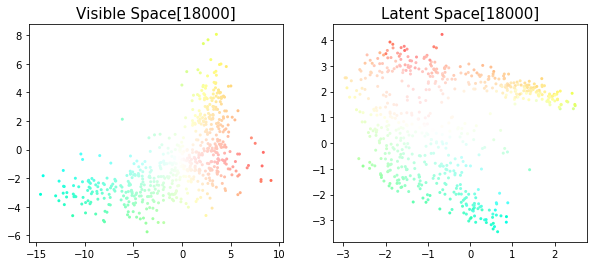

Save Model here..
Iter 19800: L_tot 302.665 L_MSE 295.185 L_divergence 7.480
Iter 21600: L_tot 453.558 L_MSE 446.549 L_divergence 7.008
Iter 23400: L_tot 339.305 L_MSE 332.219 L_divergence 7.086
Iter 25200: L_tot 273.183 L_MSE 265.895 L_divergence 7.288
Iter 27000: L_tot 314.369 L_MSE 307.105 L_divergence 7.264


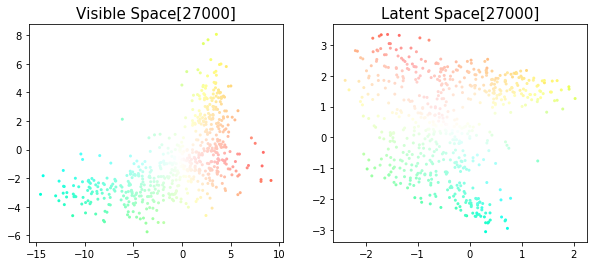

Iter 28800: L_tot 289.845 L_MSE 282.752 L_divergence 7.093
Iter 30600: L_tot 292.846 L_MSE 285.523 L_divergence 7.324
Iter 32400: L_tot 308.566 L_MSE 301.305 L_divergence 7.261
Iter 34200: L_tot 323.313 L_MSE 315.840 L_divergence 7.473
Iter 36000: L_tot 355.055 L_MSE 347.640 L_divergence 7.415


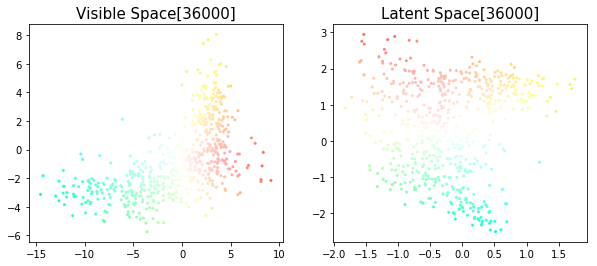

Save Model here..
Iter 37800: L_tot 308.855 L_MSE 301.524 L_divergence 7.331
Iter 39600: L_tot 251.724 L_MSE 244.159 L_divergence 7.565
Iter 41400: L_tot 290.565 L_MSE 283.157 L_divergence 7.408
Iter 43200: L_tot 291.553 L_MSE 283.965 L_divergence 7.587
Iter 45000: L_tot 319.268 L_MSE 311.805 L_divergence 7.463


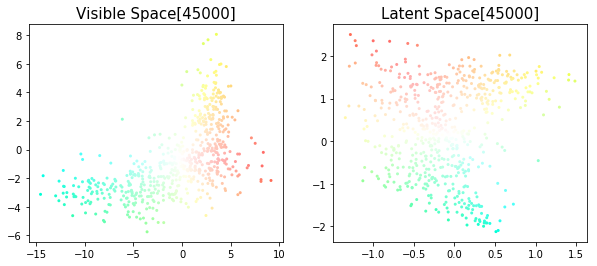

Iter 46800: L_tot 241.526 L_MSE 233.878 L_divergence 7.649
Iter 48600: L_tot 264.862 L_MSE 257.198 L_divergence 7.664
Iter 50400: L_tot 271.904 L_MSE 264.147 L_divergence 7.757
Iter 52200: L_tot 196.753 L_MSE 189.071 L_divergence 7.682
Iter 54000: L_tot 212.883 L_MSE 205.146 L_divergence 7.737


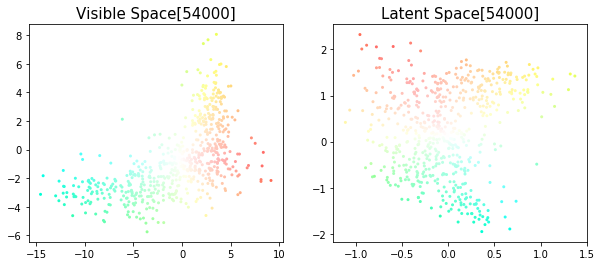

Save Model here..
Iter 55800: L_tot 283.534 L_MSE 275.796 L_divergence 7.739
Iter 57600: L_tot 245.452 L_MSE 237.778 L_divergence 7.674
Iter 59400: L_tot 266.811 L_MSE 259.164 L_divergence 7.647
Iter 61200: L_tot 241.240 L_MSE 233.354 L_divergence 7.886
Iter 63000: L_tot 258.982 L_MSE 251.149 L_divergence 7.832


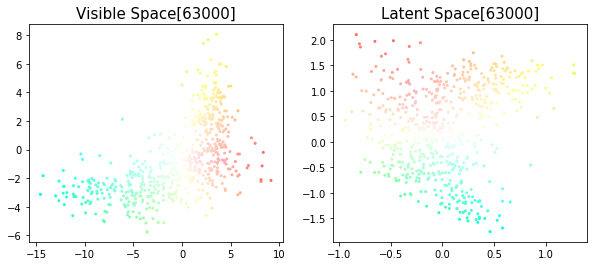

Iter 64800: L_tot 255.257 L_MSE 247.464 L_divergence 7.793
Iter 66600: L_tot 242.391 L_MSE 234.432 L_divergence 7.959
Iter 68400: L_tot 227.430 L_MSE 219.495 L_divergence 7.936
Iter 70200: L_tot 159.488 L_MSE 151.588 L_divergence 7.900
Iter 72000: L_tot 165.618 L_MSE 157.650 L_divergence 7.968


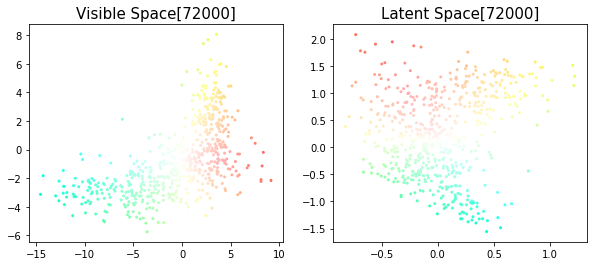

Save Model here..
Iter 73800: L_tot 218.381 L_MSE 210.400 L_divergence 7.981
Iter 75600: L_tot 191.776 L_MSE 183.702 L_divergence 8.074
Iter 77400: L_tot 199.339 L_MSE 191.299 L_divergence 8.040
Iter 79200: L_tot 169.390 L_MSE 161.260 L_divergence 8.131
Iter 81000: L_tot 182.882 L_MSE 174.721 L_divergence 8.161


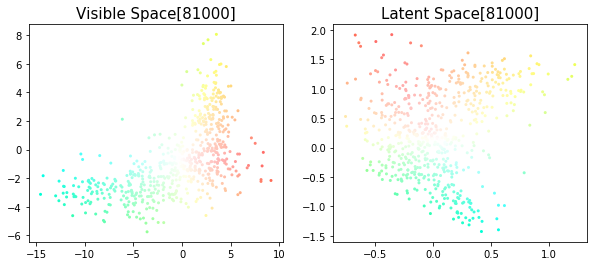

Iter 82800: L_tot 174.322 L_MSE 166.279 L_divergence 8.042
Iter 84600: L_tot 208.526 L_MSE 200.416 L_divergence 8.111
Iter 86400: L_tot 221.846 L_MSE 213.688 L_divergence 8.158
Iter 88200: L_tot 205.580 L_MSE 197.385 L_divergence 8.195
Iter 90000: L_tot 257.450 L_MSE 249.277 L_divergence 8.174


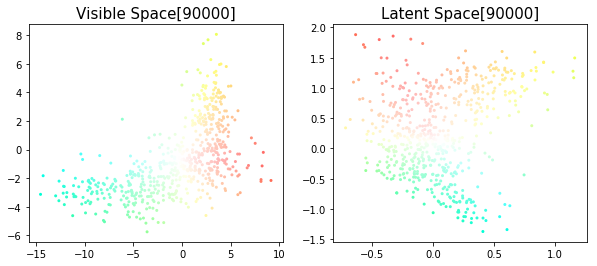

Save Model here..
Iter 91800: L_tot 232.238 L_MSE 224.006 L_divergence 8.232
Iter 93600: L_tot 235.228 L_MSE 227.084 L_divergence 8.144
Iter 95400: L_tot 193.677 L_MSE 185.491 L_divergence 8.186
Iter 97200: L_tot 170.641 L_MSE 162.438 L_divergence 8.202
Iter 99000: L_tot 198.971 L_MSE 190.746 L_divergence 8.226


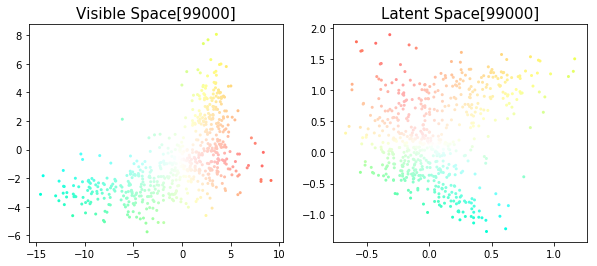

Iter 100800: L_tot 181.234 L_MSE 173.013 L_divergence 8.221
Iter 102600: L_tot 207.791 L_MSE 199.523 L_divergence 8.268
Iter 104400: L_tot 215.489 L_MSE 207.178 L_divergence 8.311
Iter 106200: L_tot 232.428 L_MSE 224.175 L_divergence 8.253
Iter 108000: L_tot 194.255 L_MSE 185.940 L_divergence 8.315


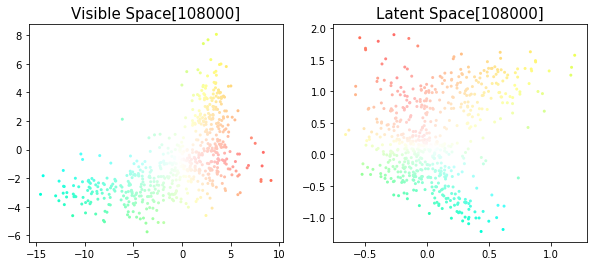

Save Model here..
Iter 109800: L_tot 181.453 L_MSE 173.150 L_divergence 8.303
Iter 111600: L_tot 229.770 L_MSE 221.380 L_divergence 8.389
Iter 113400: L_tot 234.724 L_MSE 226.459 L_divergence 8.266
Iter 115200: L_tot 213.478 L_MSE 205.152 L_divergence 8.326
Iter 117000: L_tot 235.331 L_MSE 226.998 L_divergence 8.333


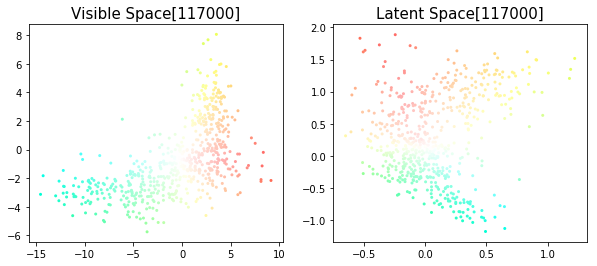

Iter 118800: L_tot 177.678 L_MSE 169.282 L_divergence 8.396
Iter 120600: L_tot 236.782 L_MSE 228.352 L_divergence 8.431
Iter 122400: L_tot 182.199 L_MSE 173.748 L_divergence 8.452
Iter 124200: L_tot 207.606 L_MSE 199.157 L_divergence 8.449
Iter 126000: L_tot 236.717 L_MSE 228.321 L_divergence 8.396


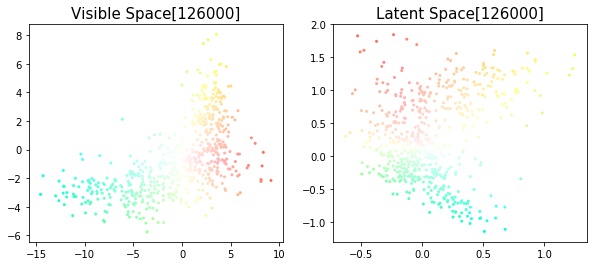

Save Model here..
Iter 127800: L_tot 178.422 L_MSE 170.018 L_divergence 8.404
Iter 129600: L_tot 222.481 L_MSE 214.039 L_divergence 8.443
Iter 131400: L_tot 209.792 L_MSE 201.355 L_divergence 8.437
Iter 133200: L_tot 214.548 L_MSE 206.158 L_divergence 8.390
Iter 135000: L_tot 267.048 L_MSE 258.574 L_divergence 8.474


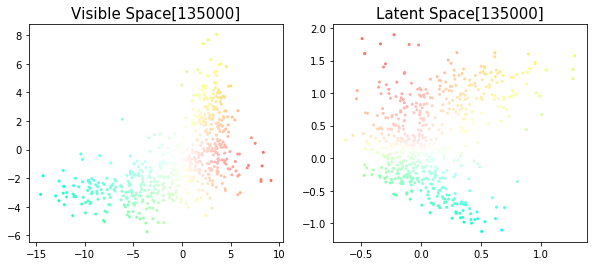

Iter 136800: L_tot 242.947 L_MSE 234.501 L_divergence 8.446
Iter 138600: L_tot 151.597 L_MSE 143.125 L_divergence 8.472
Iter 140400: L_tot 173.790 L_MSE 165.429 L_divergence 8.361
Iter 142200: L_tot 191.906 L_MSE 183.547 L_divergence 8.359
Iter 144000: L_tot 241.253 L_MSE 232.815 L_divergence 8.438


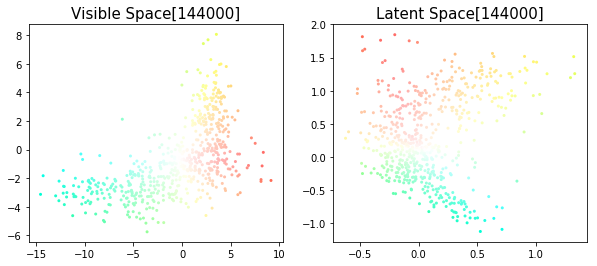

Save Model here..
Iter 145800: L_tot 220.399 L_MSE 211.906 L_divergence 8.492
Iter 147600: L_tot 300.819 L_MSE 292.389 L_divergence 8.431
Iter 149400: L_tot 213.513 L_MSE 205.152 L_divergence 8.361
Iter 151200: L_tot 254.147 L_MSE 245.610 L_divergence 8.537
Iter 153000: L_tot 165.613 L_MSE 157.225 L_divergence 8.388


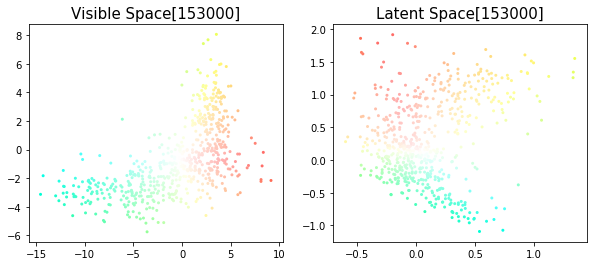

Iter 154800: L_tot 174.525 L_MSE 166.068 L_divergence 8.456
Iter 156600: L_tot 167.036 L_MSE 158.510 L_divergence 8.526
Iter 158400: L_tot 212.716 L_MSE 204.294 L_divergence 8.422
Iter 160200: L_tot 199.400 L_MSE 190.833 L_divergence 8.567
Iter 162000: L_tot 191.295 L_MSE 182.862 L_divergence 8.433


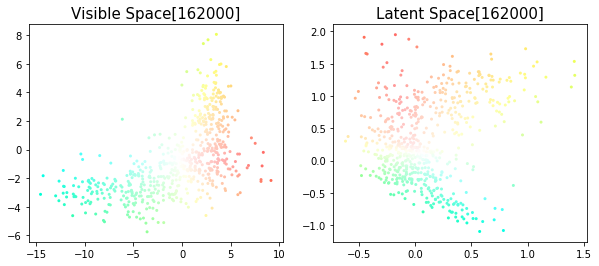

Save Model here..
Iter 163800: L_tot 172.152 L_MSE 163.673 L_divergence 8.479
Iter 165600: L_tot 186.627 L_MSE 178.175 L_divergence 8.452
Iter 167400: L_tot 197.616 L_MSE 189.132 L_divergence 8.484
Iter 169200: L_tot 194.561 L_MSE 186.061 L_divergence 8.500
Iter 171000: L_tot 225.781 L_MSE 217.279 L_divergence 8.503


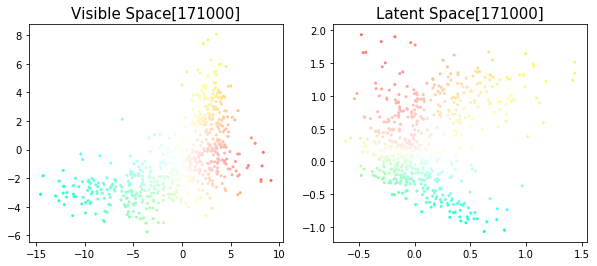

Iter 172800: L_tot 171.857 L_MSE 163.388 L_divergence 8.469
Iter 174600: L_tot 168.999 L_MSE 160.513 L_divergence 8.486
Iter 176400: L_tot 203.037 L_MSE 194.536 L_divergence 8.501
Iter 178200: L_tot 156.616 L_MSE 148.070 L_divergence 8.546


In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

for iteration in range(n_iter):
    batch, cur_idx = next_batch(train_data, cur_idx, batch_size)
    batch_target = add_noise(batch)

    _, tot_loss, loss_mse, loss_divergence = sess.run(
        (train_op, loss, mse, KL_divergence),
        feed_dict={x_hat: batch, x: batch_target, keep_prob: 0.9}
    )

    if iteration % logs_step == 0:
        # Print Cost..
        print('Iter %d: L_tot %03.3f L_MSE %03.3f L_divergence %03.3f' % (iteration, tot_loss, loss_mse, loss_divergence))
    if iteration % draw_step == 0:
        latent = sess.run(z, feed_dict={x_hat:test_data, keep_prob: 1.0})
        scatter_2_data(test_data, latent, titles=["Visible Space[%d]" % iteration, "Latent Space[%d]" % iteration], c1=test_rgb_color, c2=test_rgb_color, figsize=(10, 4))
    if iteration % save_step == 0 and iteration > 0:
        # Save Model
        print("Save Model here..")

In [20]:
print(latent.mean(), latent.std())

0.20536406 0.5080765


### Test

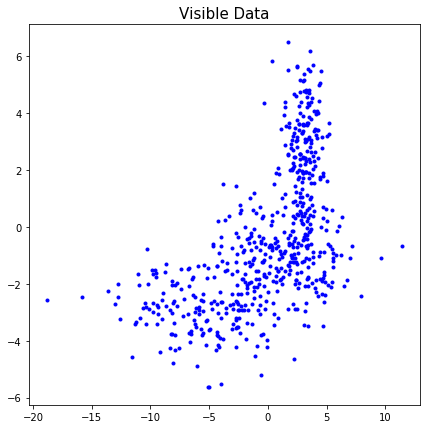

In [46]:
scatter_data(test_data[:,0], test_data[:,1], title="Visible Data", c='b', linewidths=1)

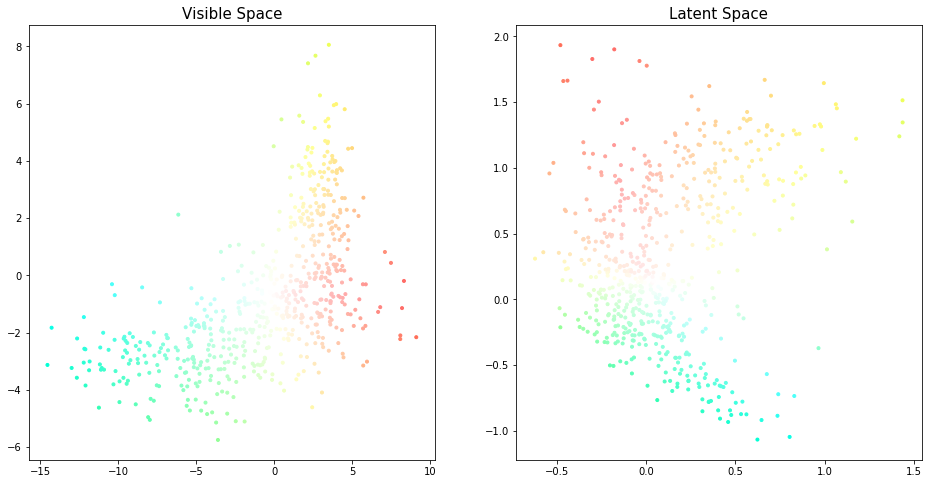

In [21]:
scatter_2_data(test_data, latent, titles=["Visible Space", "Latent Space"], c1=test_rgb_color, c2=test_rgb_color, linewidths=1, figsize=(16, 8))

In [20]:
generated_data.shape

(1, 2)

In [21]:
generated_data

array([[ 5.440579 , -1.6313483]], dtype=float32)

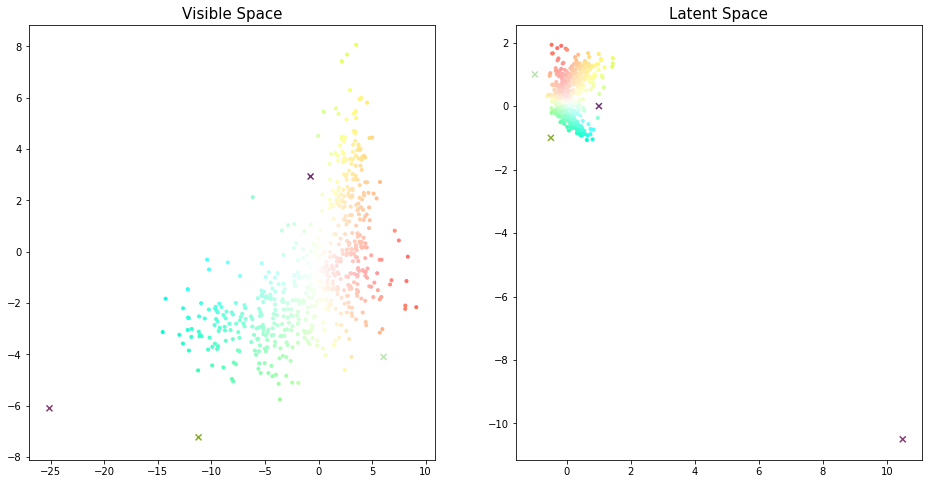

In [29]:
test_sample = np.array([[100, 100], [100, -100], [-100, -100], [-100, 100]])
test_sample = np.array([[1.0, 0.0], [10.5, -10.5], [-1.0, 1.0], [-0.5, -1.0]])
generated_data = sess.run(decoded, feed_dict={z_in:test_sample, keep_prob:1.0})

scatter_2_data_test_sample(test_data, latent, generated_data, test_sample, linewidths=1, titles=["Visible Space", "Latent Space"], c1=test_rgb_color, c2=test_rgb_color, figsize=(16, 8))


In [ ]:
scatter_2_data_test_sample